In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# Load and clean data
data = pd.read_excel('Cervical Cancer Datasets_.xlsx')

# 1. Data Cleaning
# Clean HPV Test Result column
data['HPV Test Result'] = data['HPV Test Result'].astype(str).str.upper().str.strip()
data['HPV Test Result'] = data['HPV Test Result'].replace({
    'NEGAGTIVE': 'NEGATIVE',
    'POSITIVE<BR>': 'POSITIVE',
    'POSITIVE\n': 'POSITIVE'
})

# 2. Target Variable Creation
data['High Risk'] = ((data['HPV Test Result'] == 'POSITIVE') | 
                    (data['Pap Smear Result'] == 'Y')).astype(int)

# 3. Feature Selection with Proper Copy
features = data[['Age', 'Sexual Partners', 'First Sexual Activity Age',
                'HPV Test Result', 'Pap Smear Result', 'Smoking Status',
                'STDs History', 'Region', 'Insrance Covered']].copy()

# 4. Categorical Encoding
cat_cols = ['HPV Test Result', 'Pap Smear Result', 'Smoking Status',
           'STDs History', 'Region', 'Insrance Covered']

# Option 1: Label Encoding (Recommended)
for col in cat_cols:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col].astype(str))

# Option 2: One-Hot Encoding (Alternative)
# from sklearn.preprocessing import OneHotEncoder
# features = pd.get_dummies(features, columns=cat_cols)

# 5. Verify Data Types
print("\nFinal Data Types:")
print(features.dtypes)

# 6. Split Data
X = features
y = data['High Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Train Model with Proper Configuration
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    # enable_categorical=True  # Only needed if using pandas category dtype
)

model.fit(X_train, y_train)

# 8. Evaluate
y_pred = model.predict(X_test)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 9. Feature Importance
print("\nFeature Importance:")
importance = model.get_booster().get_score(importance_type='weight')
for k, v in sorted(importance.items(), key=lambda item: item[1], reverse=True):
    print(f"{k}: {v}")


Final Data Types:
Age                          int64
Sexual Partners              int64
First Sexual Activity Age    int64
HPV Test Result              int32
Pap Smear Result             int32
Smoking Status               int32
STDs History                 int32
Region                       int32
Insrance Covered             int32
dtype: object

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


Feature Importance:
HPV Test Result: 35.0
Pap Smear Result: 27.0
Insrance Covered: 22.0
Region: 18.0
STDs History: 15.0
Sexual Partners: 13.0
Smoking Status: 9.0
First Sexual Activity Age: 7.0
Age: 5.0


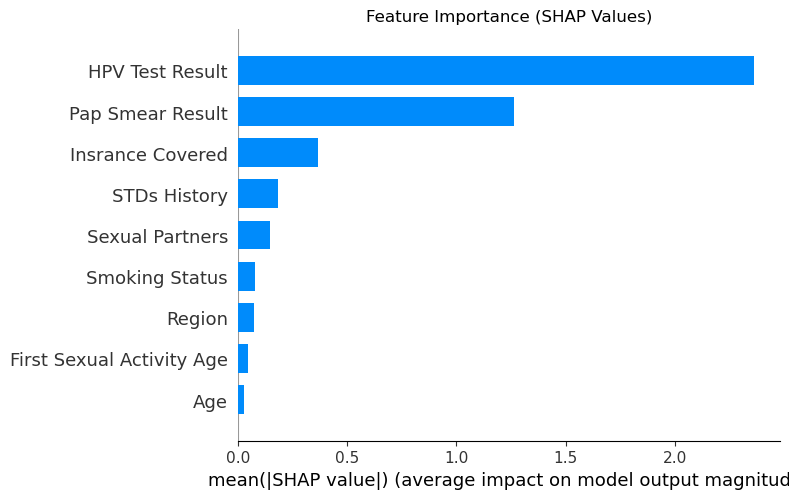

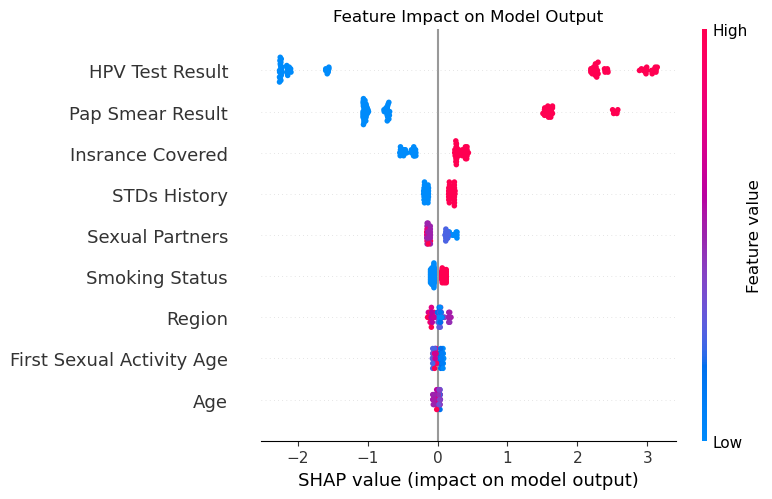

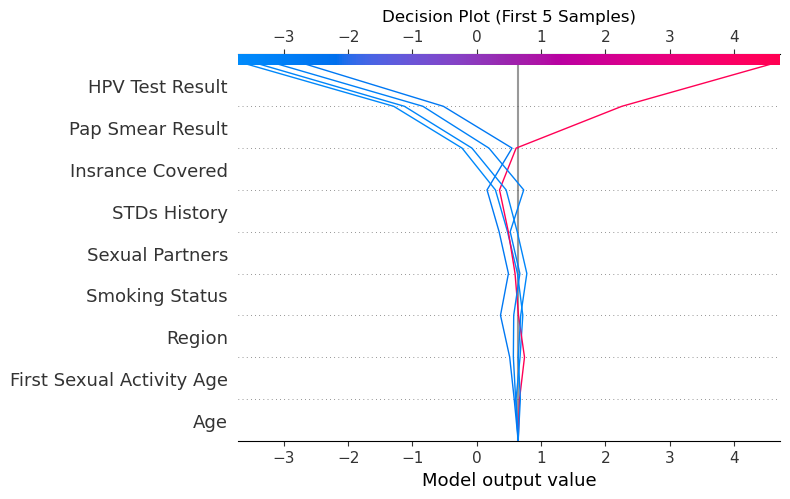

<Figure size 1000x400 with 0 Axes>

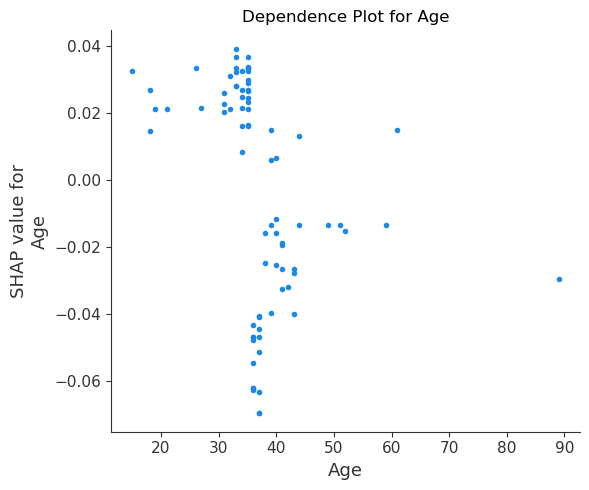

<Figure size 1000x400 with 0 Axes>

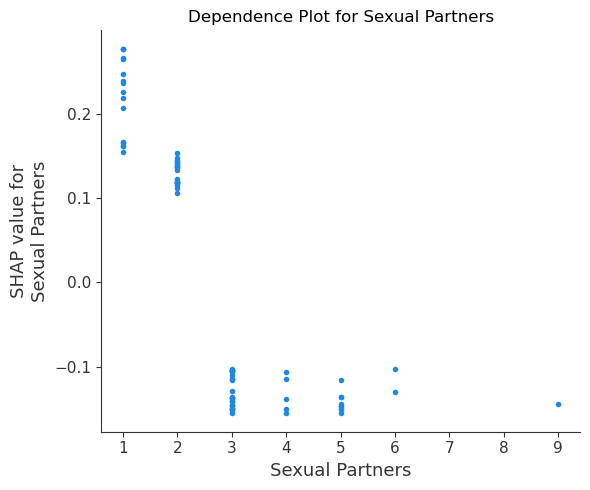

<Figure size 1000x400 with 0 Axes>

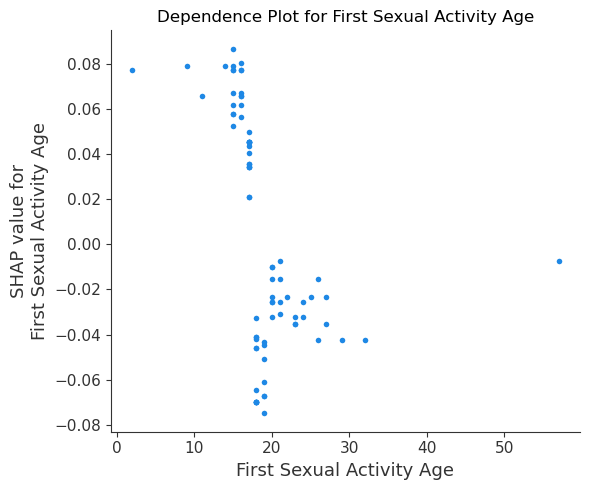

In [28]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP explainer with the correct prediction function
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# 1. Summary Plot (Feature Importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.title("Feature Importance (SHAP Values)")
plt.tight_layout()
plt.show()

# 2. Beeswarm Plot (Global Explanation)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, show=False)
plt.title("Feature Impact on Model Output")
plt.tight_layout()
plt.show()

# 3. Fixed Force Plot for Single Prediction
sample_idx = 0  # Change this to see different examples
shap.initjs()  # Initialize JavaScript visualization
display(shap.force_plot(
    explainer.expected_value, 
    shap_values[sample_idx,:], 
    X_train.iloc[sample_idx,:],
    feature_names=X_train.columns.tolist()
))

# 4. Decision Plot (Fixed)
plt.figure(figsize=(10, 6))
shap.decision_plot(
    explainer.expected_value, 
    shap_values[:5],  # First 5 samples
    feature_names=X_train.columns.tolist(),
    show=False
)
plt.title("Decision Plot (First 5 Samples)")
plt.tight_layout()
plt.show()

# 5. Dependence Plots for Top Features
for feature in X_train.columns[:3]:  # Top 3 features
    plt.figure(figsize=(10, 4))
    shap.dependence_plot(
        feature,
        shap_values, 
        X_train,
        interaction_index=None,
        show=False
    )
    plt.title(f"Dependence Plot for {feature}")
    plt.tight_layout()
    plt.show()